In [1]:
1+1

2

In [181]:
#imports from tigramite notebook
# Imports
import numpy as np
import matplotlib
#matplotlib.use('PDF')
from matplotlib import pyplot as plt
#get_ipython().magic('matplotlib inline')
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import sklearn

from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import ParCorr, GPDC, CMIknn, CMIsymb
#from tigramite.models import LinearMediation, Prediction

from netCDF4 import Dataset as NetCDFFile
import os
import numpy.ma as ma
import pandas as pd
import xarray as xr
from scipy.signal import argrelextrema


method='parcor'
#tower=['DE-Hai.DD.2000.2012.nc']#[ 'DE-Tha.HH.1996.2014.nc'] #['DE-Hai.HH.2000.2012.nc']#, 'DE-Tha.DD.1996.2014.nc', 'FR-Pue.DD.2000.2014.nc', 'US-Ton.DD.2001.2014.nc']
pc_alpha=0.2 #'None'
minlength=5 #minimal timeseries length in years
tau_min=0
tau_max=2
step=91
mask_type='y'
extent="inter" #"intra") #inter or intra # irrelevant for MovingWindow
Dataset='Jake'
hour_mask_use=['noon1']
attribute2=''
attribute=''
quality_value=0.9

alpha_level=0.01
windowstep=1
step=5
reso=48
T_hot=37
event_mask_use=['999th_percT+-20']
var_names = ["Rg","T","NEE","VPD","H","LE",'SWC1']
random_selection=None
number_of_random_sampling=3
if random_selection is None:
    number_of_random_sampling=1
give_up_timeorder=False

results_df=pd.DataFrame(columns=["T_NEE","T_LE","LE_NEE","Rg_NEE","Rg_LE", "T_NEE_q","T_LE_q","LE_NEE_q","Rg_NEE_q","Rg_LE_q", "T_max_day","T_max_window","T_mean","P_sum_window","P_sum_5daysbefore","P_sum_10daysbefore","P_sum_5daysafter","P_sum_10daysafter","Tower", "EventNr","Event","windowwidth", "Lat",'Lon'])

def meanseason(data,year):
    keys=data.keys()
    values=data.values
    #year_mask with yearly values is needed, though if extent=inter is choosen, above year_mask is useless. therefore generate an own mask
    L,W=data.shape
    ys2=np.unique(year,return_inverse=True)
    year_mask2 = np.ones((L,W,len(ys2[0])))
    dummy=np.ones((365*48,W,len(ys2[0])))*(-9999)
    meanyear=np.zeros((365*48,W))
    anomaly=ma.copy(values)
    #create year mask
    for (i,y) in enumerate(ys2[0].astype(int)):
        year_mask2[np.where(year==y),:,i]=0
    # create year masked arrays
    data_frame={y: pp.DataFrame(values,mask=year_mask2[:,:,i]) for (i,y) in enumerate(ys2[0].astype(int))}
    # calculate meanyear with masked missing values
    for (i,y) in enumerate(ys2[0].astype(int)):
        dummy[:,:,i]=data_frame[y].values[np.where(data_frame[y].mask[:,0]==0)][0:365*48]
    meanyear=ma.masked_values(dummy,-9999).mean(axis=2)
    meanyear=pd.DataFrame(data=meanyear,columns=keys)
    return meanyear

def meanseason_smooth(data,year):
    # calc meanseason
    meanyear=meanseason(data,year)
    keys=meanyear.keys()
    values=meanyear.values

    #smooth meanseason
    meanyear_ft= scipy.fftpack.rfft(values,axis=0)
    meanyear_ft[20:365]=0
    meanyear_smoth=scipy.fftpack.irfft(meanyear_ft,axis=0)
    meanyear_smoth=pd.DataFrame(data=meanyear_smoth,columns=keys)
    return meanyear_smoth

def anomaly(data,year):
    anomaly=data.copy()
    meanyear=meanseason(data,year)
    keys=anomaly.keys()
    values=anomaly.values
    ys2=np.unique(year,return_inverse=True)
    #then subtract season mean from each year [0:365]-> leap year day 366 stays unchanged
    for (i,y) in enumerate(ys2[0].astype(int)):
        values[np.where(ys2[1]==i)[0][0:365]]-=meanyear.values
        if np.where(ys2[1]==i)[0].shape ==(366,):
             values[np.where(ys2[1]==i)[0][365]]-=meanyear.values[364]

    anomaly=pd.DataFrame(data=values,columns=keys)
    return anomaly


def anomaly_smooth(data,year):
    anomaly_smooth=data.copy()
    meanyear_smoth=meanseason_smooth(data,year)
    keys=anomaly_smooth.keys()
    values=anomaly_smooth.values
    ys2=np.unique(year,return_inverse=True)
    #then subtract season mean from each year [0:365]-> leap year day 366 stays unchanged
    for (i,y) in enumerate(ys2[0].astype(int)):
        values[np.where(ys2[1]==i)[0][0:365]]-=meanyear_smoth.values
        if np.where(ys2[1]==i)[0].shape ==(366,):
             values[np.where(ys2[1]==i)[0][365]]-=meanyear_smoth.values[364]

    anomaly_smooth=pd.DataFrame(data=values,columns=keys)
    return anomaly_smooth

def noprocessing(data,year):
    return data

processings={"_":noprocessing,"meanseason":meanseason, "meanseason_smooth":meanseason_smooth, "anomaly": anomaly, "anomaly_smooth": anomaly_smooth }

def processing_select(processing,data,time):
    return processings[processing](data,time)

##########
#function calling PCMCI
def RunPCMCI(con_ind_test,selected_variables,dataframe,pc_alpha,tau_min,tau_max,alpha_level):
    pcmci= PCMCI(selected_variables = selected_variables,
                  dataframe=dataframe,
                  cond_ind_test=con_ind_test,
                      verbosity=0)
    results = pcmci.run_pcmci(tau_min=tau_min,tau_max=tau_max,pc_alpha=pc_alpha, fdr_method='fdr_bh')
    return results

def RunMCI(con_ind_test,selected_variables,dataframe,pc_alpha,var_names,tau_min,tau_max,alpha_level):
    pcmci= PCMCI(selected_variables = selected_variables,
                  dataframe=dataframe,
                  cond_ind_test=con_ind_test,
                  var_names=var_names,
                      verbosity=1)
    results = pcmci.run_mci(tau_min=tau_min,tau_max=tau_max,parents=None)

    pcmci._print_significant_links(p_matrix=results['p_matrix'],
           val_matrix=results['val_matrix'], alpha_level=alpha_level)

    link_matrix_q = pcmci._return_significant_parents(pq_matrix=results['p_matrix'],
            val_matrix=results['val_matrix'], alpha_level=alpha_level)['link_matrix']
    return results


def store_datapoints_establishing_LE_T(var1,var2,results,T_bin,rs,random_indices,dataframe):
    var1_ind=np.where(np.array(var_names)==var1)
    var2_ind=np.where(np.array(var_names)==var2)
    if results['p_matrix'][var1_ind,var2_ind,0]<alpha_level:
        dataframe.loc[random_indices,(T_bin,rs)]=1
        
        
def store_datapoints_removing_LE_T(var1,var2,results,T_bin,rs,random_indices,dataframe):
    var1_ind=np.where(np.array(var_names)==var1)
    var2_ind=np.where(np.array(var_names)==var2)
    if results['p_matrix'][var1_ind,var2_ind,0]>alpha_level:
        dataframe.loc[random_indices,(T_bin,rs)]=1


        
##########

####
#create dictionary with cond ind tests
use_mask=True
mask_type='y'
con_ind_tests={'parcor': ParCorr(significance='analytic', mask_type=mask_type, confidence='analytic', verbosity=0 ),
#      'gpdc': GPDC(significance='analytic', gp_params=None,verbosity=1,use_mask=use_mask, confidence='bootstrap', mask_type='y',recycle_residuals=True),
#      'gpace' : GPACE(significance='analytic', gp_params=None,verbosity=1,use_mask=use_mask, mask_type='y', ace_version='acepack',recycle_residuals=True),
#       'cmiknn' : CMIknn(significance='shuffle_test', knn=50,recycle_residuals=True)
      }
method='parcor'

con_ind_test = con_ind_tests[method]
##################

if Dataset=="short":
    with open('../Data/FluxtowerLists/Without-9999-short.txt', 'r') as towerfile:
        towers=towerfile.read().split('\n')
elif Dataset=="long":
    towers=os.listdir( "/home/christopher/BGI/data/DataStructureMDI/DATA/Incoming/Fluxnet/berkeley_012016/Data/HH/2016_11")
#    towers=["IT-CA1.HH.2011.2014.nc","IT-CA2.HH.2011.2014.nc","IT-CA3.HH.2011.2014.nc","FR-LBr.HH.1996.2008.nc","ZM-Mon.HH.2000.2009.nc","US-MMS.HH.1999.2014.nc","FR-Pue.HH.2000.2014.nc","CN-Qia.HH.2003.2005.nc","IT-Ro1.HH.2000.2008.nc","IT-Ro2.HH.2002.2012.nc"]
 #   towers=['DE-Tha.HH.1996.2014.nc']
    #towers=['DE-Hai.DD.2000.2012.nc']#, 'DE-Tha.DD.1996.2014.nc']
elif Dataset=='Jake':
    towers=os.listdir("/home/christopher/BGI/work_2/fluxnet-BGI/data")
#    towers=os.listdir("/Net/Groups/BGI/work_2/fluxnet-BGI/data")

#savepath="/Net/Groups/BGI/scratch/ckrich/Projects/Decoupling_ET-GPP"
savepath="/home/christopher/BGI/scratch/ckrich/Projects/Decoupling_ET-GPP"
#savepath=".."


#Towers_Tmax=pd.DataFrame(columns=["Tower", "T_max_5"])

In [6]:
tower_tmax=pd.read_csv("/home/christopher/BGI/people/ckrich/Projects/Decoupling_ET-GPP/Data/Dataframe_Tower_Tmax.csv")

In [114]:
tower_tmax.tail()["Tower"].values

array(['AU-Gin', 'CA-NS1', 'AU-Stp', 'AU-GWW', 'AU-Cpr'], dtype=object)

In [100]:
ts_TEA

<xarray.Dataset>
Dimensions:       (latitude: 1, longitude: 1, time: 70128)
Coordinates:
  * latitude      (latitude) float64 -31.38
  * longitude     (longitude) float64 115.7
  * time          (time) datetime64[ns] 2011-01-01T00:15:00 ... 2014-12-31T23:45:00.000013
Data variables:
    NT_training   (time, latitude, longitude) float64 dask.array<shape=(70128, 1, 1), chunksize=(17520, 1, 1)>
    TEA_T_NT_50   (time, latitude, longitude) float64 dask.array<shape=(70128, 1, 1), chunksize=(17520, 1, 1)>
    TEA_T_NT_55   (time, latitude, longitude) float64 dask.array<shape=(70128, 1, 1), chunksize=(17520, 1, 1)>
    TEA_T_NT_60   (time, latitude, longitude) float64 dask.array<shape=(70128, 1, 1), chunksize=(17520, 1, 1)>
    TEA_T_NT_65   (time, latitude, longitude) float64 dask.array<shape=(70128, 1, 1), chunksize=(17520, 1, 1)>
    TEA_T_NT_70   (time, latitude, longitude) float64 dask.array<shape=(70128, 1, 1), chunksize=(17520, 1, 1)>
    TEA_T_NT_75   (time, latitude, longitude) floa

AU-Gin
AU-Gin
finishedreadingData


/home/christopher/anaconda3/envs/tigraClust/lib/python3.7/site-packages/pandas/core/computation/expressions.py:183: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  .format(op=op_str, alt_op=unsupported[op_str]))


processing:  _
noon1
(46, 38)
Start Calculation
(38, 35)
Start Calculation
(35, 33)
Start Calculation


/home/christopher/anaconda3/envs/tigraClust/lib/python3.7/site-packages/tigramite-4.0.0b0-py3.7-linux-x86_64.egg/tigramite/plotting.py:951: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  frameon=False)
/home/christopher/anaconda3/envs/tigraClust/lib/python3.7/site-packages/tigramite-4.0.0b0-py3.7-linux-x86_64.egg/tigramite/plotting.py:1055: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  frameon=False)


(33, 31)
Start Calculation
(31, 29)
Start Calculation
(29, 28)
Start Calculation
(28, 27)
Start Calculation
(27, 25)
Start Calculation
(25, 24)
Start Calculation
(24, 23)
Start Calculation
(23, 21)
Start Calculation


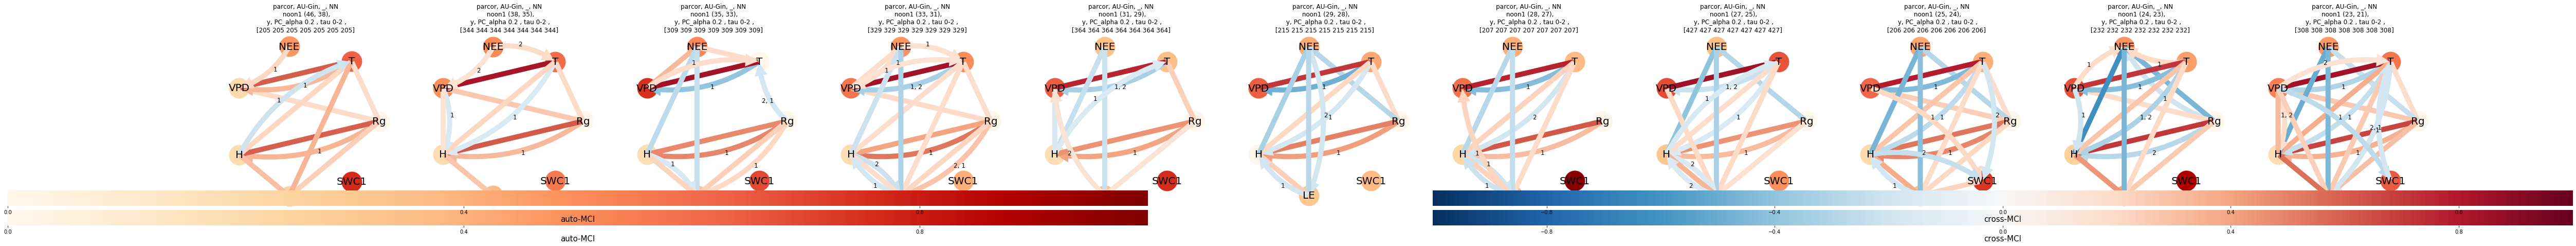

In [285]:
fig, axes = plt.subplots(nrows=1, ncols=11, figsize=(7*11,7*1), squeeze=False)
fig.subplots_adjust(top=0.88)


for t,fluxtower in enumerate(tower_tmax.tail()["Tower"].values[0:1]):  # -1 because last line in tower is empty.
    random_indices_dataframe=pd.DataFrame(columns=["T_bin", "random_sampling", "random_indices"])

    print(fluxtower)
  #  if not fluxtower[0:6]=='US-Ne1':
   #     continue
    filename='%s%s' % (fluxtower, attribute)
    if Dataset=="long":
 #       path="/Net/Groups/BGI/data/DataStructureMDI/DATA/Incoming/Fluxnet/berkeley_012016/Data/DD/2016_11"
        path="/home/christopher/BGI/data/DataStructureMDI/DATA/Incoming/Fluxnet/berkeley_012016/Data/HH/2016_11"
        if os.path.isfile('%s/%s' %  (path, towers[t])) == False:
            print('not found: %s/%s' %  (path, towers[t]))
            continue
        print("found",fluxtower)
        ts=NetCDFFile('%s/%s' % (path,towers[t]))
        L=len(ts.dimensions["time"])
        if L/minlength<365:
            print("TS too short")
            continue
        var_names_dict={"Rg": "SW_IN_F", "T": "TA_F", "VPD": "VPD_F", "NEE": "NEE_VUT_USTAR50", "LE": "LE_CORR", "H": "H_CORR","SWC1":"SWC_F_MDS_1","P":"P_F","GPP":"GPP_NT_CUT_MEAN"  }
        var_names_QC_dict={"Rg": "SW_IN_F", "T": "TA_F", "VPD": "VPD_F", "NEE": "NEE_VUT_USTAR50", "LE": "LE_F_MDS", "H": "H_F_MDS","SWC1":"SWC_F_MDS_1","P":"P_F","GPP":"NEE_VUT_USTAR50" }

        Data_dict={}
        Data_q_dict={}
        for var in var_names:
            Data_dict[var]=np.squeeze(ts.variables[var_names_dict[var]][:])
            Data_q_dict[var]=np.squeeze(ts.variables[var_names_QC_dict[var]+'_QC'][:])

        hour=np.squeeze(ts.variables["hour"])#
        minute=np.squeeze(ts.variables["minute"])#
        month=np.squeeze(ts.variables["month"])#
        day=np.squeeze(ts.variables["day"])#;
        year=np.squeeze(ts.variables["year"])#[:]
        Rg_pot=np.squeeze(ts.variables["SW_IN_POT"])
        precip=np.squeeze(ts.variables[var_names_dict["P"]][:])

        Data=ma.array(list(Data_dict.values())).T
        Data_q=ma.array(list(Data_q_dict.values())).T

        Data.mask=Data_q.mask
        Data.data[Data_q.data==-9999]=-9999
        Data[np.isnan(Data)]=-9999
        
        #set data to missing value if quality flag = 1 (might be hard, but needed to kick out Hainich last years)
      #  Data[Data_q==3]=-9999
        Data=np.ma.array(Data, mask=Data==-9999,keep_mask=True)
        print("finishedreadingData")

    elif Dataset=='Jake':
        print(fluxtower)
        path='/home/christopher/BGI/work_2/fluxnet-BGI/data/%s/eddy_covariance/L1_raw/' % fluxtower
        #path='/Net/Groups/BGI/work_2/fluxnet-BGI/data/%s/eddy_covariance/L1_daily/' % fluxtower
        try:
            ts = xr.open_mfdataset(path +fluxtower+'.HH.*.nc')
        except:
            try: 
                ts = xr.open_mfdataset(path +fluxtower+'.HR.*.nc')
            except:
                continue
        path_TEA='/home/christopher/BGI/work_2/fluxnet-BGI/data/%s/TEA/L1_raw/' % fluxtower
        ts_TEA = xr.open_mfdataset(path_TEA +fluxtower+'.HH.*.nc')

        var_names_dict={"Rg": "SW_IN", "T": "TA", "VPD": "VPD", "NEE": "NEE", "LE": "LE", "H": "H","GPP":"GPP_NT","SWC1":"SWC_1", "P":"P" }
        var_names_QC_dict={"Rg": "SW_IN", "T": "TA", "VPD": "VPD", "NEE": "NEE", "LE": "LE", "H": "H","GPP":"NEE","SWC1":"SWC_1", "P":"P" }
        
    #    T=np.squeeze(ts.variables[var_names_dict['T']][:]).values
     #   Towers_Tmax=Towers_Tmax.append({"Tower": fluxtower,"T_max_5":np.nanmax(T)}, ignore_index=True)
      

  
        GPP=np.squeeze(ts.variables[var_names_dict['GPP']][:]).values
        Rg_pot=np.squeeze(ts.variables['SW_IN_POT'][:]).values
        precip=np.squeeze(ts.variables[var_names_dict['P']][:]).values
    #    GPP_q=np.squeeze(ts.variables[var_names_dict['GPP']+'_QC'][:]).values
        try:
            IGBP=ts.attrs['IGBP_class']
        except:
            IGBP='NN'
        time=pd.DatetimeIndex(np.squeeze(ts.variables["time"][:]).values)
        minute=time.minute
        hour=time.hour
        day=time.day
        month=time.month
        year=time.year
        L=len(year)
        

        Data_dict={}
        Data_q_dict={}
        for var in var_names:
            if "TEA" in var:
                Data_dict[var]=np.squeeze(ts_TEA.variables[var][:]).values
                Data_q_dict[var]=np.ones(L)
            else:
                Data_dict[var]=np.squeeze(ts.variables[var_names_dict[var]][:]).values
                Data_q_dict[var]=np.squeeze(ts.variables[var_names_QC_dict[var]+'_QC'][:]).values

      #  Data=np.array(list(Data_dict.values())).T
       # Data_q=np.array(list(Data_q_dict.values())).T

        Data=pd.DataFrame(Data_dict)
        Data_q=pd.DataFrame(Data_q_dict)

        print("finishedreadingData")    

  # if -9999 at one t in one variable, set the value at t to -9999 in all variables (allows effective number of datapoints for network calculation)

    Data.where(Data.notna(),-9999,inplace=True)
    Data_q.where(Data_q.notna(),-9999,inplace=True)
    Data.where(Data_q.notna(),-9999,inplace=True)
    Data[Data_q==3]=-9999

 #   Data[np.isnan(Data)]=-9999

    Data.loc[((Data==-9999).sum(axis=1)>0),:]=-9999
    #Data_q.loc[((Data==-9999).sum(axis=1)>0),:]=1

#    Data.data[((Data.data==-9999).sum(axis=1)>0),:]=-9999
 #   Data_q.data[((Data.data==-9999).sum(axis=1)>0),:]=1


    L,W,=Data.shape

    ##### Yearly mask
    ys=np.unique(year).astype(int)
    year_mask={'%s'%y: np.reshape(((year==y)==0),(L,1)) for (i,y) in enumerate(ys)} # add all years to mask
    year_mask["%s-%s"%(min(ys),max(ys))]=np.zeros((L)) #add zero mask

    # hour mask
    hour_mask_prel = np.ones((L,7))
    for i in range(0, L):
    #     print t % 365
       # if  math.floor(hour[i])==10 or math.floor(hour[i])==11 or math.floor(hour[i])==12:
      #  if julday[i] > 3*30 and julday[i] < 8*30: #and math.floor(hour[i]) % 24<9 or (math.floor(hour[i]) %24)>15:
        hour_mask_prel[i,0]=False #0-24h is used
        if hour[i]==10 or hour[i]==11 or hour[i]==12 or hour[i]==13:  #10h-13h
            hour_mask_prel[i,1]=False

    hour_mask_prel[np.where(Rg_pot!=0),2]=0 #day
    hour_mask_prel[np.where(Rg_pot==0),3]=0 #night

#    temp=(Rg_pot==0).astype(int)-np.roll(Rg_pot==0,1).astype(int)
#    sunrise=np.where(temp==-1)[0]
#    sunset=np.where(temp==1)[0]
    Rg_rel=np.zeros((len(Rg_pot)))
#    lm=argrelextrema(Rg_pot, np.greater)[0]
#    for i in range(0,len(lm)):
#        Rg_rel[sunrise[i]:sunset[i]]=Rg_pot[sunrise[i]:sunset[i]]/Rg_pot[lm[i]]

    for i in range(0,len(Rg_pot),48):
        maxima=Rg_pot[i:i+48].max()
        if maxima==0:
            continue
        Rg_rel[i:i+48]=Rg_pot[i:i+48]/maxima

    dif=Rg_rel-np.roll(Rg_rel,1,0)
    dif=np.sign(dif)


    hour_mask_prel[:,4]=((Rg_rel<4/5)*(dif>0))==0
    hour_mask_prel[:,5]=((Rg_rel>4/5))==0
    hour_mask_prel[:,6]=((Rg_rel<4/5)*(dif<0))==0


    hour_mask={'0h-24h': hour_mask_prel[:,0], '10h-13h': hour_mask_prel[:,1], 'day': hour_mask_prel[:,2], 'night': hour_mask_prel[:,3],
                'morning1': hour_mask_prel[:,4], 'noon1': hour_mask_prel[:,5], 'evening1': hour_mask_prel[:,6]}


    ### create preip mask
    #mask x whole days after precip event

    #choose a precipitation threshold above which precip days and x consecutive days are masked

    #precip_thres
    #precip_maskeddays


    precip_thres=0.01
    precip_maskeddays=10

    precip_mask=np.zeros(L,int)

    for ind,p in enumerate(precip):
        if p>precip_thres and precip_mask[ind]==0:
            hh= 2*hour[ind]+(minute[ind]>30) # # half hours at precip event
            sh= precip_maskeddays*48+(48-hh) # subsequent hours
            precip_mask[ind:ind+sh]=1

    ## define temperature masks
    #get T_max
    #take the floor
    # count # of datapoints above that value >minsamplesize? calculate network, otherwise decrease by one degree

    T=Data.loc[:,"T"]
    min_samplesize=150
    First_Bin_Det_SampSize=True
    
    T_masked=T[(precip_mask==0)*(hour_mask['noon1']==0)*(T!=-9999)]

    T_max=np.nanmax(T)
    T_max_ceil=np.ceil(T_max).astype(int)

    T_min=20
    T_min_floor=np.floor(T_min).astype(int)

    T_bins=[]

    t_prev=T_max_ceil
    for t_bin in range(T_max_ceil,T_min_floor,-1):
        t_next=t_bin
        if np.sum(T_masked>t_next)-np.sum(T_masked>t_prev)>min_samplesize:
            T_bins.append((t_prev,t_next))
            if First_Bin_Det_SampSize and t_prev==T_max_ceil:
                min_samplesize=np.sum(T_masked>t_next)-np.sum(T_masked>t_prev)
            t_prev=t_next


    T_mask_prel=np.ones((L,len(T_bins)))

    for m in range(0,len(T_bins)):
        T_mask_prel[:,m]=((T<T_bins[m][0])*(T>T_bins[m][1]))==0

    T_mask={T_bins[i]:T_mask_prel[:,i] for i in range(0,len(T_bins))}
    
    data=np.ma.array(Data.values, mask=Data==-9999,keep_mask=True)
    
    for processing in ["_"]:
        if processing=="highpass":
            pp.lowhighpass_filter(data,tau_max*5,"high")
        else:
            data=processing_select(processing,data,year)
            
        print("processing: ",processing)
        #hour_mask_use=['day'] #('0h-24h', '10h-13h', 'day', 'night')
        #event_mask_use=['Jul-Sep-2003']
        #step=step*48
        selected_variables = np.arange(1,W)
        filename='%s%s' % (fluxtower, attribute)

        for (k,h) in enumerate(hour_mask_use):
            print(h)
            for (binnr,e) in enumerate(T_mask):
                print(e)
                    #quality control:
   #                 for var in var_names:
    #                    if var=="GPP":
     #                       continue
      #                  dismiss=False
       #                 temp=eval(var+"_q")
        #                perc_bad_data+=((temp[start:stop]>2).sum())/(stop-start)
                #        dismiss+=np.any(temp[start:stop]>2)
         #               print("percentage of bad data:", perc_bad_data)
          #          if perc_bad_data>1:
           #             continue
                #    if dismiss>0:
                #        print("dismissed",fluxtower,n)
                #        continue
                    # check for rain
                #    if P_sum_window>0.001:
                #        print("Precip in window")
                #        continue
                #    if P_sum_5daysbefore>0.001:
                #        print("Precip in 5days ahead")
                #        continue
                    # start moving window
                print('Start Calculation')


 

                columns = pd.MultiIndex.from_tuples([(T_bins[0],0)], names=['T_bin', 'rs'])
                df_t=pd.DataFrame(index=np.linspace(0,L,L,endpoint=False,dtype=int),columns=columns).rename_axis('Index')
                df_f=pd.DataFrame(index=np.linspace(0,L,L,endpoint=False,dtype=int),columns=columns).rename_axis('Index')

    

                for rs in range(number_of_random_sampling):
                    data_mask= ((T_mask[e]==0)*(precip_mask==0)*(hour_mask[h]==0))==0
                    if random_selection is not None:
                        rand_indices=np.random.choice(np.where(data_mask==False)[0],random_selection,replace=False)
                        rand_selector=np.ones(L)
                        rand_selector[rand_indices]=0
                        data_mask=rand_selector
                        temp=pd.DataFrame(np.array([T_bins[m],rs,rand_indices])[np.newaxis,:],columns=["T_bin", "random_sampling", "random_indices"])
                        random_indices_dataframe=random_indices_dataframe.append(temp,ignore_index=True)

                    if give_up_timeorder:
                        dataframe = pp.DataFrame(data[rand_indices], mask=data_mask[rand_indices,np.newaxis].repeat(W,axis=1), missing_flag=-9999,var_names=var_names)
                    else:
                        dataframe = pp.DataFrame(data.data, mask=data_mask[:,np.newaxis].repeat(W,axis=1),missing_flag=-9999,var_names=var_names)

         #           plt.figure(figsize=(20,6))
         #           plt.plot(data[:,-2])
          #          plt.plot(data_mask*50)
           #         plt.show()

       #             plt.figure(figsize=(20,6))
        #            plt.plot(data[data_mask==0,1]-e[0])
         #           for v,var in enumerate(var_names):    
          #              plt.plot((data[data_mask==0,v]-data[data_mask==0,v].min(axis=0))/(data[data_mask==0,v].max(axis=0)-data[data_mask==0,v].min(axis=0))+v/2)
           #         plt.show()
              #      plt.plot(dataframe.values[dataframe.mask[:,0]==0,2:5]/dataframe.values.max(axis=0)[2:5])
                 #   plt.show()
               #     plt.plot(dataframe.values[dataframe.mask[:,0]==0,5:]/dataframe.values.max(axis=0)[5:])
                #    plt.show()

                #    results=np.load("../Outputs/['Rg', 'T', 'NEE', 'VPD', 'H', 'LE']/DE-Hai.HH.2000.2012.nc/Data/parcor/91/01_Results_DE-Hai.HH.2000.2012.nc___y_2000_summer_day_25.07-20.08_parcor_0.4_0_25.npy").item()
                    try:
                        results = RunPCMCI(con_ind_test, selected_variables, dataframe, pc_alpha,tau_min,tau_max,alpha_level)
                    except:
                        continue

 #                   store_datapoints_establishing_LE_T("T","LE",results,T_bins[t],rs,rand_indices,df_t)
  #                  store_datapoints_removing_LE_T("T","LE",results,T_bins[t],rs,rand_indices,df_f)
  

                    number_of_datapoints=((data==-9999)[data_mask==0]==0).sum(axis=0)

                    axes[t,binnr].set_title('%s, %s, %s, %s \n %s %s, \n %s, PC_alpha %s , tau %s-%s ,%s \n %s  ' % (method, fluxtower, processing, IGBP, h, e, mask_type, pc_alpha, tau_min, tau_max, attribute2, number_of_datapoints))

                    tp.plot_graph(
                        fig_ax=(fig,axes[t,binnr]),
                        val_matrix=results['val_matrix'],
                        link_matrix=results['p_matrix']<alpha_level,
                        var_names=var_names,
                        link_colorbar_label='cross-MCI',
                        node_colorbar_label='auto-MCI',
                        arrow_linewidth=50,
                        node_size=40,
                        label_fontsize=15,
                        node_label_size=20,
                    #    curved_radius=0.5,
                        link_label_fontsize=12,
                        show_colorbar=True,
                        )
plt.show()
               

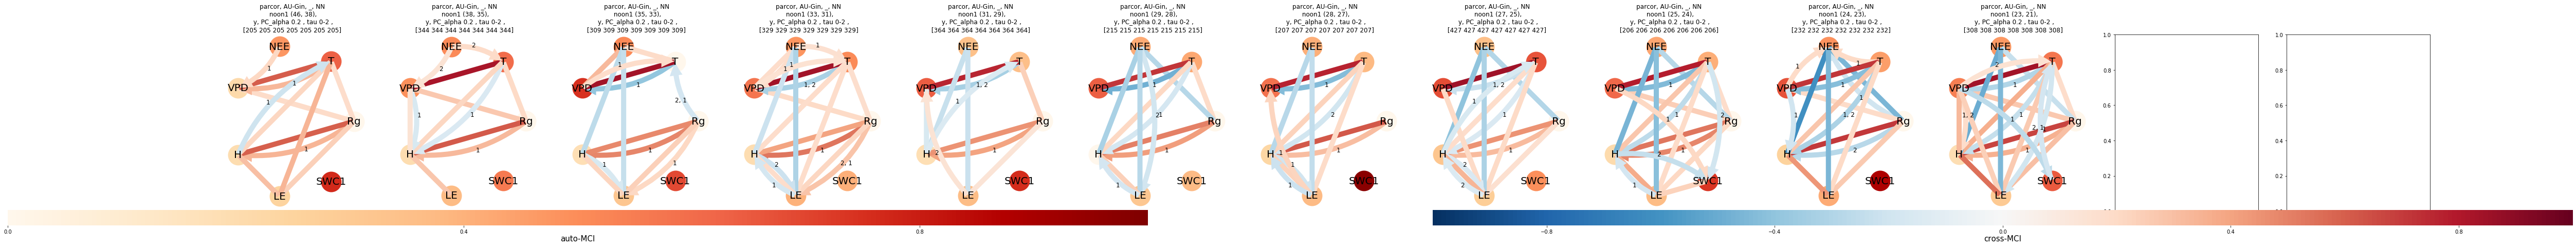

In [284]:
fig

In [281]:
fig.axes

In [287]:
fig.axes[-1].axes.remove()

In [288]:
fig.savefig("../fig6AU-Gin.pdf")